In [4]:
from utils import shimming_magnet


import numpy as np


X = np.linspace(-300,300,100)
Y = np.linspace(-300,300,100)
Z = np.linspace(-300,300,100)

x,y,z = np.meshgrid(X,Y,Z,indexing='ij')
y2,z2 = np.meshgrid(Y,Z,indexing='ij')

alphas = np.linspace(0,2*np.pi,2,endpoint=False)
shim_radius = 250e-3
positions = []
for alpha in alphas: 
    position = [0,shim_radius*np.cos(alpha),shim_radius*np.sin(alpha)]
    positions.append(position)

magnets = []
for pos in positions:
    #print(pos)
    magnet = shimming_magnet.shimming_magnet(position = pos)
    magnet.render_field(grid=[x,y,z])
    magnets.append(magnet)

nummagnets = len(magnets)


magnet created, dipole points to  [0. 1. 0.]
magnet created, dipole points to  [0. 1. 0.]


In [3]:

fldsY = np.zeros((np.shape(magnet.B0[:,:,:,1])+(nummagnets,)))
fldsZ = np.zeros((np.shape(magnet.B0[:,:,:,2])+(nummagnets,)))

for i,magnet in enumerate(magnets):
    fldsY[:,:,:,i] = (magnet.B0[:,:,:,1])
    fldsZ[:,:,:,i] = (magnet.B0[:,:,:,2])
    
angleofrotation = 0*np.pi/6
vector_of_magnet_rotations = np.zeros(len(magnets))+angleofrotation


#shimField = np.matmul(fldsY,np.sin(vector_of_magnet_rotations)) + np.matmul(fldsZ,np.cos(vector_of_magnet_rotations))
shimField = np.matmul(fldsZ,np.cos(vector_of_magnet_rotations)) + np.matmul(fldsY,np.sin(vector_of_magnet_rotations))

print(np.shape(shimField))

fld = magnet.Brot*0

print(np.shape(fld))

for i,magnet in enumerate(magnets):
    angle = vector_of_magnet_rotations[i]
    magnet.rotate_field(angle)
    fld+=magnet.Brot
    
print(vector_of_magnet_rotations*0+2*np.pi)



print('masking')
DSV=shim_radius*1.05*1e3
sphereMask = np.zeros(np.shape(x), dtype = bool)
sphereMask[np.square(x) + np.square(y) + np.square(z) <= (DSV/2)**2] = 1 
sphereMask = np.asarray(sphereMask, dtype=np.double)
sphereMask[sphereMask == 0] = np.nan

for i,magnet in enumerate(magnets):
    fldsY[:,:,:,i] = np.multiply(sphereMask, fldsY[:,:,:,i])
    fldsZ[:,:,:,i] = np.multiply(sphereMask, fldsZ[:,:,:,i])
    
shimField = np.matmul(fldsZ,np.cos(vector_of_magnet_rotations)) + np.matmul(fldsY,np.sin(vector_of_magnet_rotations))

shimField_nanmasked = shimField[~np.isnan(shimField)]
print(np.shape(shimField))
print(np.shape(shimField_nanmasked))

fld = np.multiply(sphereMask,fld)


import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes(111)#,projection='3d')  
#ctrf = ax.plot_surface(y2,z2,fld,cmap='viridis',edgecolor='black')#zdir = 'x', offset = fld, alpha=0.5,cmap='viridis',edgecolor='black',vmin = np.nanmin(fld), vmax = np.nanmax(fld),levels=64)
minval_of_b0 = np.nanmin(shimField)
maxval_of_b0 = np.nanmax(shimField)

idx = 70
#fld_slc = fld[idx,:,:]
fld_slc=shimField[idx,:,:]
ax.cla()
ax.contourf(y2,z2,fld_slc, offset = 0, alpha=0.5,cmap='viridis',edgecolor='black',vmin = minval_of_b0/1e4, vmax = maxval_of_b0/1e4,levels=64)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Shim Magnets Field X=%.2f, angles = %.2f deg'%(X[idx],angleofrotation*180/np.pi))

#plt.xlim(-100,100)
#plt.ylim(-100,100)


plt.show()



(100, 100, 100)
(100, 100, 100)
[6.28318531 6.28318531]


masking
(100, 100, 100)
(42584,)
[2]


IndexError: list assignment index out of range

C:\Users\kuliko02\AppData\Local\Temp\1\ipykernel_18608\188339775.py:13: UserWarning: The following kwargs were not used by contour: 'offset', 'edgecolor'
  ax.contourf(y2,z2,fld_slc, offset = 0, alpha=0.5,cmap='viridis',edgecolor='black',vmin = minval_of_b0/1e4, vmax = maxval_of_b0/1e4,levels=64)


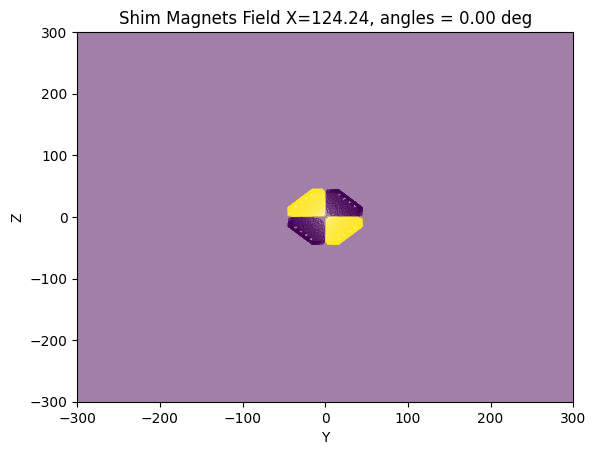

In [204]:

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes(111)#,projection='3d')  
#ctrf = ax.plot_surface(y2,z2,fld,cmap='viridis',edgecolor='black')#zdir = 'x', offset = fld, alpha=0.5,cmap='viridis',edgecolor='black',vmin = np.nanmin(fld), vmax = np.nanmax(fld),levels=64)
minval_of_b0 = np.nanmin(shimField)
maxval_of_b0 = np.nanmax(shimField)

idx = 70
#fld_slc = fld[idx,:,:]
fld_slc=shimField[idx,:,:]
ax.cla()
ax.contourf(y2,z2,fld_slc, offset = 0, alpha=0.5,cmap='viridis',edgecolor='black',vmin = minval_of_b0/1e4, vmax = maxval_of_b0/1e4,levels=64)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Shim Magnets Field X=%.2f, angles = %.2f deg'%(X[idx],angleofrotation*180/np.pi))

#plt.xlim(-100,100)
#plt.ylim(-100,100)


plt.show()


In [ ]:
print('lets mask out the fields')
import scipy.ndimage as cp # for erosion

def cartToSpher(coords):
    r = np.sqrt(np.sum(np.square(coords),axis = -1))    
    #remove r = 0 to avoid divide by zero
    r[r==0] = np.nan
    
    phi = np.arctan2(coords[...,0], coords[...,1]) + np.pi
    theta = np.arccos(coords[...,2]/r)
    return np.stack([r,theta, phi], axis = -1)

xDim = X
yDim = Y
zDim = Z

xDim3D, yDim3D, zDim3D = np.meshgrid(xDim, yDim, zDim, indexing = 'ij')
spherCoord = cartToSpher(np.stack((xDim3D,yDim3D, zDim3D), axis = -1))

#Apply mask to data
DSV_mask = 246#e-3

mask = (np.round(spherCoord[...,0],4) <= (DSV_mask/2)).astype(float)
halfMask = mask #*((zDim3D<=0).astype(float))
erodedMask = cp.binary_erosion(halfMask.astype(bool))                    # remove the outer surface of the initial spherical mask
halfMask = np.array(halfMask.astype(bool)^erodedMask, dtype = float)   # create a new mask by looking at the difference between the inital and eroded mask
halfMask[halfMask == 0] = np.nan    
mask[mask == 0] = np.nan



In [6]:
print('Echo Test')
import numpy as np

initialGuess = np.load('vector_of_magnet_rotations.npy')
fldsZ = np.load('fldsZ.npy')
fldsY = np.load('fldsY.npy')
interpolatedField_masked = np.load('interpolatedField_masked.npy')

def _calculate_shimming_error(vector_of_magnet_rotations):
            '''calculate the shim field of shim magnets that are turned as vector_of_magnet_rotations says'''
            cheapField = np.matmul(fldsZ,np.cos(vector_of_magnet_rotations)) + np.matmul(fldsY,np.sin(vector_of_magnet_rotations)) + interpolatedField_masked
            cheapField = cheapField[~np.isnan(cheapField)]

            return np.square((cheapField/np.mean(cheapField)-1))*1e14
        

from scipy.optimize import least_squares


lsqData = least_squares(_calculate_shimming_error, initialGuess, ftol=1e-32, xtol=0, max_nfev=10000, verbose=2, bounds=(initialGuess*0,initialGuess*0+2*np.pi))

optimized_rotation_vector = lsqData.x

totfield = np.matmul(fldsZ,np.cos(optimized_rotation_vector)) + np.matmul(fldsY,np.sin(optimized_rotation_vector)) + interpolatedField_masked

newhomo = (np.nanmax(totfield)-np.nanmin(totfield))/np.nanmean(totfield)*1e6
print('new homo: %.0f ppm'%newhomo)


def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for alpha in optimized_rotation_vector:
                 x=0
                 y=0
                 z=0
                 dirx = 0
                 diry = 0
                 dirz = 0     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('output_angles_in_ring_format.txt')




Echo Test
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3748e+15                                    3.47e+11    
       1              6         1.3748e+15      1.36e+08       1.79e-02       3.24e+11    


C:\Users\kuliko02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_lsq\least_squares.py:824: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  ftol, xtol, gtol = check_tolerance(ftol, xtol, gtol, method)
C:\Users\kuliko02\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_lsq\least_squares.py:824: UserWarning: Setting `xtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  ftol, xtol, gtol = check_tolerance(ftol, xtol, gtol, method)


       2              7         1.3748e+15      1.69e+09       3.72e-03       4.17e+11    
       3              8         1.3748e+15      1.02e+09       3.75e-03       1.61e+11    
       4              9         1.3748e+15      1.41e+09       2.63e-03       5.18e+11    
       5             10         1.3748e+15      1.50e+09       7.02e-03       2.85e+11    
       6             11         1.3748e+15      1.85e+09       6.16e-03       5.11e+11    
       7             12         1.3748e+15      1.91e+09       7.10e-03       3.51e+11    
       8             13         1.3748e+15      1.09e+09       6.61e-03       3.77e+11    
       9             14         1.3748e+15      2.15e+09       6.27e-03       2.73e+11    
      10             15         1.3748e+15      2.14e+09       6.19e-03       3.52e+11    
      11             16         1.3748e+15      1.27e+09       6.61e-03       2.36e+12    
      12             18         1.3748e+15      5.52e+08       2.93e-03       3.55e+11    

KeyboardInterrupt: 